# Homework week 2 - Paolo Zinesi

Acronyms:
- RSA: Relative Species Abundance (plots absolute counts of species with a given abundance)
- SAD: Species Abundance Distribution (plots percentages of species with a given abundance)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import nbinom
import statsmodels.api as sm

## Data visualization and preprocessing

In [2]:
# sampled fraction
p = 0.01

# import data in a dataframe
rawdata = pd.read_excel("RSA_sampled_1percent.xlsx", header=None, names=["n_individuals"])
rawdata

/Users/paolozinesi/anaconda3/lib/python3.9/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


,n_individuals
0,6
1,10
2,5
3,5
4,12
...,...
4278,4
4279,27
4280,2
4281,4


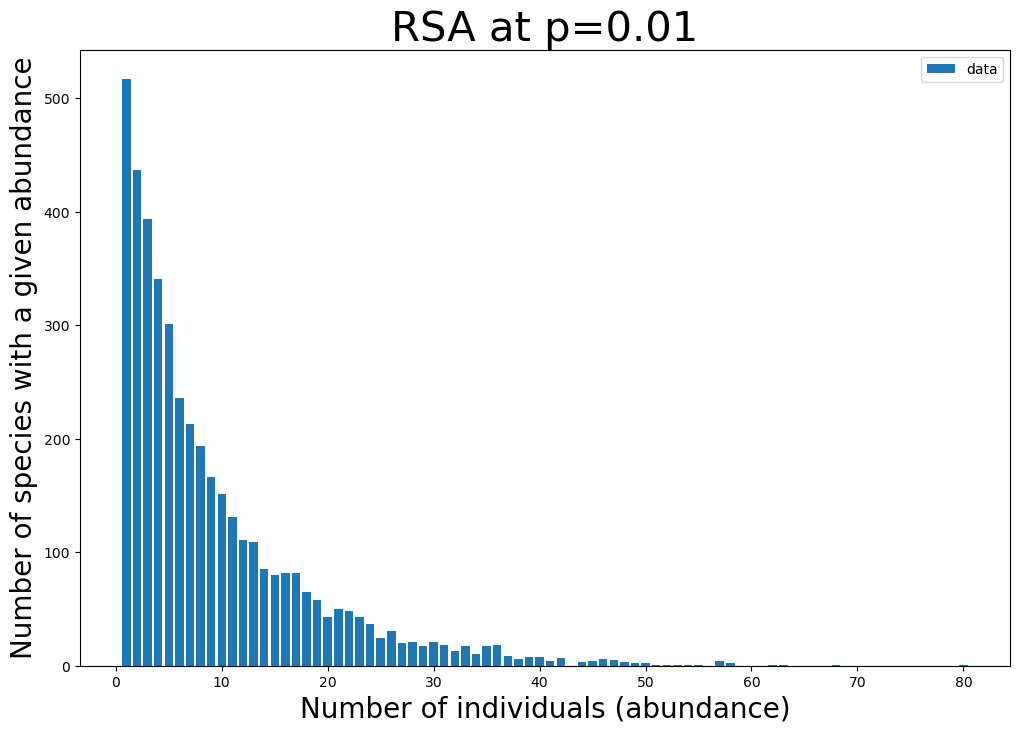

In [3]:
# count number of species in each abundance class
species_abundance, n_species = np.unique(rawdata, return_counts=True)

# plot Relative Species Abundance (RSA)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
ax.bar(species_abundance, n_species, label="data")
ax.set_title(f"RSA at p={p}", fontsize=30)
ax.set_xlabel("Number of individuals (abundance)", fontsize=20)
ax.set_ylabel("Number of species with a given abundance", fontsize=20)
ax.legend()

In [4]:
# create a dataframe to store all the processed RSA data
SAD_data = pd.DataFrame({"abundance":species_abundance, "species_number":n_species})

# group in abundance classes (Preston)
SAD_data["Preston_class"] = SAD_data["abundance"].map(lambda x: int(np.floor(np.log2(x))+1))
SAD_data = SAD_data[["Preston_class", "species_number"]].groupby(["Preston_class"]).sum()
SAD_data["species_prob"] = SAD_data["species_number"]/sum(SAD_data["species_number"])
SAD_data.reset_index(inplace=True)
SAD_data

,Preston_class,species_number,species_prob
0,1,517,0.120710
1,2,831,0.194023
2,3,1091,0.254728
3,4,1027,0.239785
4,5,660,0.154098
5,6,155,0.036190
6,7,2,0.000467


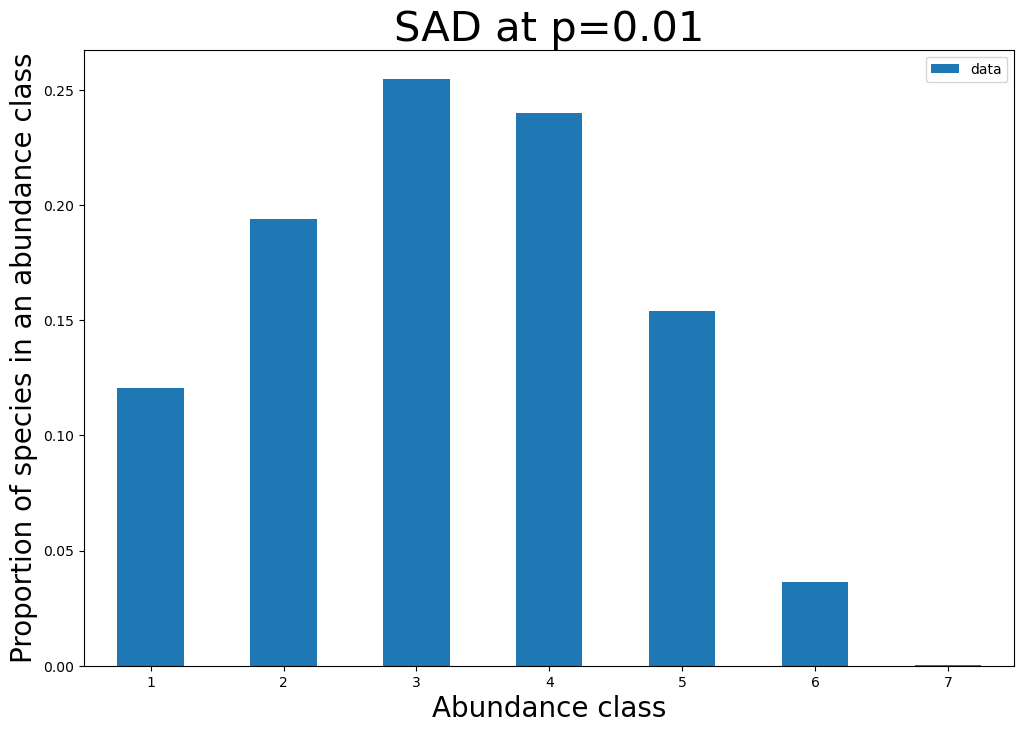

In [5]:
# plot Species Abundance Distribution (SAD) grouped in abundance classes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

SAD_data.plot.bar(x="Preston_class", y="species_prob", rot=0, ax=ax, label="data")
ax.set_title(f"SAD at p={p}", fontsize=30)
ax.set_xlabel("Abundance class", fontsize=20)
ax.set_ylabel("Proportion of species in an abundance class", fontsize=20)
ax.legend()

# Fit of the Species Abundance Distribution (SAD)

In order to perform the Negative Binomial (NB) fit we use `statsmodels` library. Given a NB defined as
$$ NB(k | \hat{r}_p, \hat{\xi}_p) = \binom{k+\hat{r}_p-1}{k}\, \hat{\xi}_p^k\, (1-\hat{\xi}_p)^{\hat{r}_p}$$
the library estimates the parameters
$$ \alpha = \frac{1}{\hat{r}_p},\quad \text{const} = \ln{\mu} = \ln{\left[\hat{r}_p \frac{\hat{\xi}_p}{1-\hat{\xi}_p}\right]}$$

These relations can be inverted to get the values of the parameters of our interest
$$ \hat{r}_p = \frac{1}{\alpha},\quad \hat{\xi}_p = \left[1+\frac{1}{\alpha}\, e^{-\text{const}} \right]^{-1} $$


In [6]:
# negative binomial fit
res = sm.NegativeBinomial(rawdata.values, np.ones_like(rawdata.values)).fit(start_params=[1,1])
print(res.summary())

Optimization terminated successfully.
         Current function value: 3.257850
         Iterations: 8
         Function evaluations: 9
         Gradient evaluations: 9
                     NegativeBinomial Regression Results                      
Dep. Variable:                      y   No. Observations:                 4283
Model:               NegativeBinomial   Df Residuals:                     4282
Method:                           MLE   Df Model:                            0
Date:                Wed, 26 Oct 2022   Pseudo R-squ.:               1.930e-11
Time:                        14:35:40   Log-Likelihood:                -13953.
converged:                       True   LL-Null:                       -13953.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2287      0.014    160.7

In [7]:
# estimation of parameters at scale p
csi_p = 1/(1 + (np.exp(-res.params[0])/res.params[1]))
r_p = 1/res.params[1]
NB_p = nbinom(r_p, 1-csi_p)

print(f"Estimated values at scale p: r_p = {round(r_p,3)}, csi_p = {round(csi_p,3)}")

Estimated values at scale p: r_p = 1.397, csi_p = 0.869


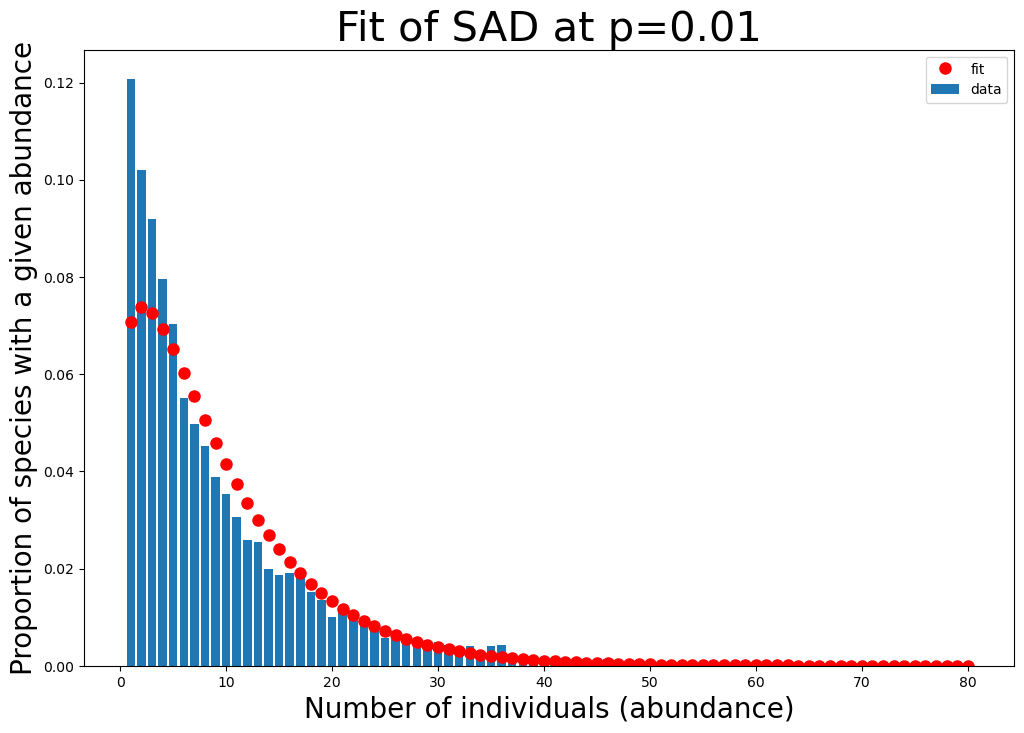

In [8]:
# plot SAD and fit
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
x0 = np.arange(1,max(rawdata["n_individuals"])+1,1)

ax.bar(species_abundance, n_species/sum(n_species), label="data")
ax.plot(x0, NB_p.pmf(x0), 'ro', markersize=8, label="fit")
ax.set_title(f"Fit of SAD at p={p}", fontsize=30)
ax.set_xlabel("Number of individuals (abundance)", fontsize=20)
ax.set_ylabel("Proportion of species with a given abundance", fontsize=20)
ax.legend()

In [9]:
# create a dataframe to store fitted data
SAD_fit = pd.DataFrame({"abundance":[i for i in range(1, max(species_abundance)+1)]})
SAD_fit["species_prob"] = NB_p.pmf(SAD_fit["abundance"])

# group in abundance classes (Preston)
SAD_fit["Preston_class"] = SAD_fit["abundance"].map(lambda x: int(np.floor(np.log2(x)+1)))
SAD_fit = SAD_fit[["Preston_class", "species_prob"]].groupby(["Preston_class"]).sum()
SAD_fit.reset_index(inplace=True)
SAD_fit

,Preston_class,species_prob
0,1,0.070783
1,2,0.146344
2,3,0.250191
3,4,0.289659
4,5,0.160463
5,6,0.023935
6,7,0.000313


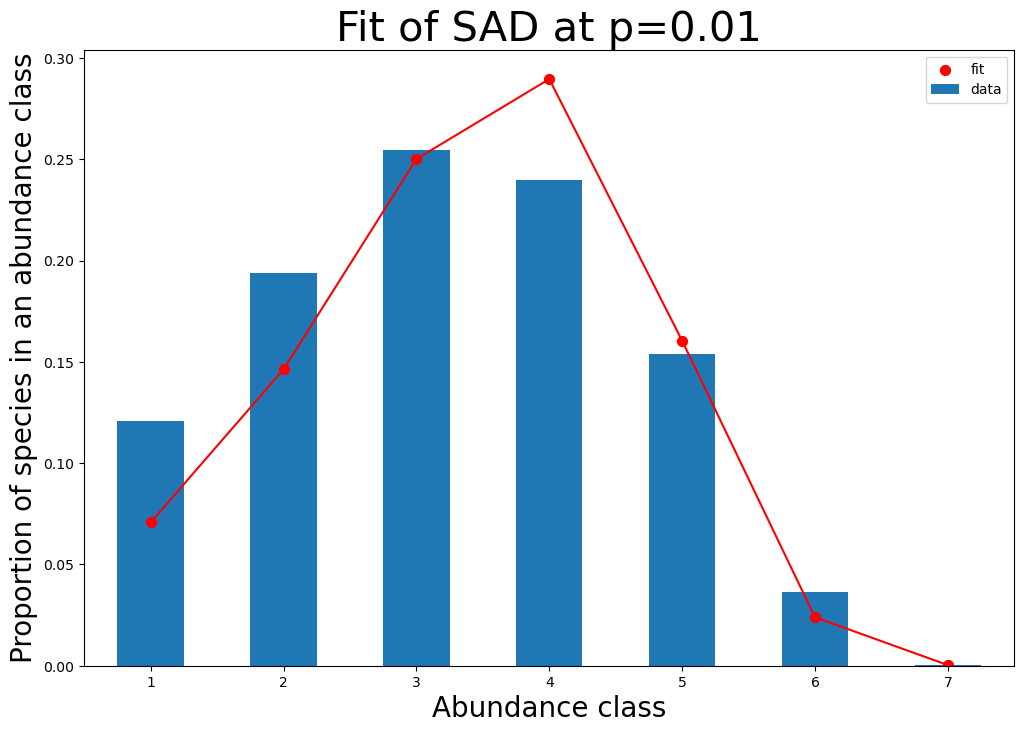

In [10]:
# plot fitted RSA grouped in abundance classes
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

SAD_data.plot.bar(x="Preston_class", y="species_prob", rot=0, ax=ax, label="data")
ax.plot(SAD_fit["Preston_class"]-1, SAD_fit["species_prob"], c="red")
ax.scatter(x=SAD_fit["Preston_class"]-1, y=SAD_fit["species_prob"], c="red", s=50, label="fit")
ax.set_title(f"Fit of SAD at p={p}", fontsize=30)
ax.set_xlabel("Abundance class", fontsize=20)
ax.set_ylabel("Proportion of species in an abundance class", fontsize=20)
ax.legend()

## Inference of the distribution at full scale (p=1)
The SAD at full scale is still a Negative Binomial defined as
$$NB(k | r, \xi) = \binom{k+r-1}{k}\, \xi^k\, (1-\xi)^{r}$$

The parameters of this distribution are related to the parameters of the previously fitted distribution by
$$r = \hat{r}_p,\quad \xi = \frac{\hat{\xi}_p}{p + \hat{\xi}_p\, (1-p)}$$

In [11]:
# estimated parameter at full scale
r = r_p
csi = csi_p/(p + csi_p*(1-p))
NB_full = nbinom(r, 1-csi)

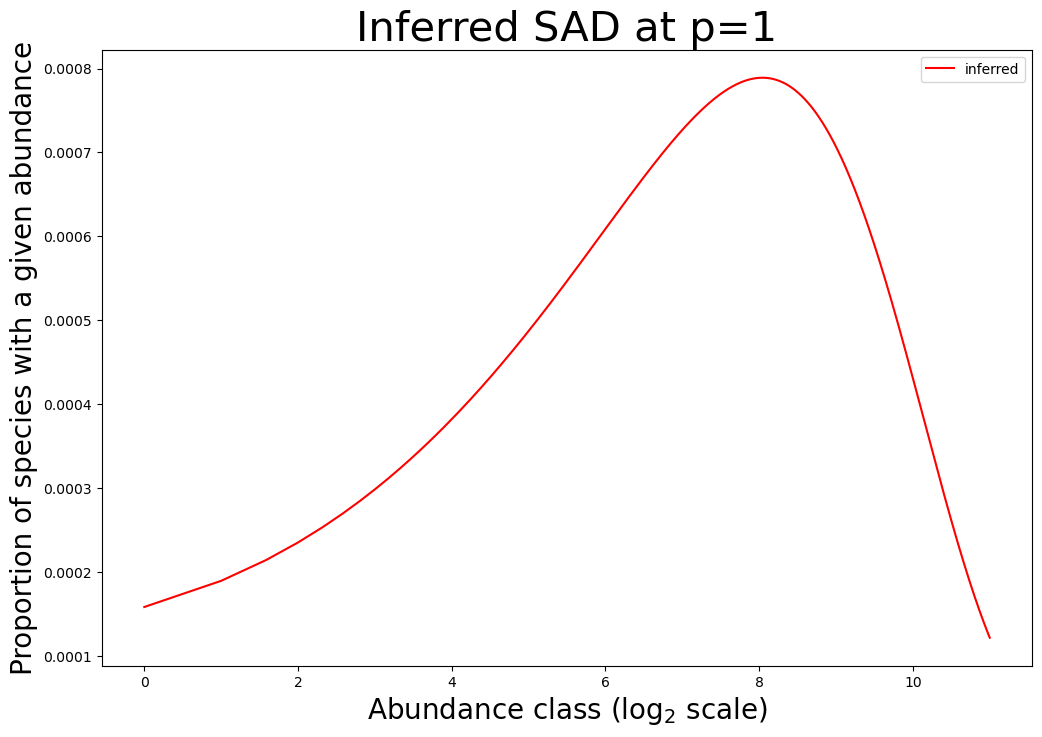

In [12]:
# plot RSA at full scale
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
x0 = np.arange(1,2048+1,1)
x0_log2 = np.log2(x0)

ax.plot(x0_log2, NB_full.pmf(x0), 'r', markersize=8, label="inferred")
ax.set_title(f"Inferred SAD at p=1", fontsize=30)
ax.set_xlabel("Abundance class (log$_2$ scale)", fontsize=20)
ax.set_ylabel("Proportion of species with a given abundance", fontsize=20)
ax.legend()

## Estimation of the number of species in total

Given the number of species at scale $p$, $S^{(p)}$, and the parameters of the two binomial distributions, the total number of species at full scale, $S$, can be estimated as
$$ S = S^{(p)} \frac{1-(1-\xi)^r}{1-(1-\hat{\xi}_p)^r} $$

In [13]:
# estimate number of species at full scale
S_p = len(rawdata)
S_tot = round(S_p * (1-(1-csi)**r)/(1-(1-csi_p)**r))
print(f"Number of species in the sample (p={p}):\t{S_p}")
print(f"Estimated number of species at full scale:\t{S_tot}")

Number of species in the sample (p=0.01):	4283
Estimated number of species at full scale:	4548
